In [1]:
# This notebook illustrates example outputs from Funman, and how to work with the ParameterSpace object it creates.

# The file scratch/hackathon/hackathon_fall_2023_demo_terarrium.py was used to generate the outputs rendered here.

SAVED_RESULTS_DIR = "./out"

# Import funman related code
import os
from funman.api.run import Runner
from funman_demo import summarize_results
from funman_demo.example.pde import plot_spatial_timeseries
from IPython.display import HTML
import matplotlib.pyplot as plt
import itertools
from funman import FunmanWorkRequest, EncodingSchedule

import json
from funman.representation.constraint import LinearConstraint, ParameterConstraint, StateVariableConstraint
from funman.representation import Interval
from funman import FUNMANConfig
import logging
from funman_demo import summarize_results



RESOURCES = "../resources"
EXAMPLE_DIR = os.path.join(RESOURCES, "amr", "petrinet", "terrarium-tests")
MODEL_PATH = os.path.join(
    EXAMPLE_DIR,"seird.json"
)
REQUEST_PATH = os.path.join(
    EXAMPLE_DIR, "seird_request.json"
)


# EXAMPLE_DIR = os.path.join(RESOURCES, "amr", "petrinet", "stratified")
# MODEL_PATH = os.path.join(
#     EXAMPLE_DIR,"model_amr.json"
# )
# REQUEST_PATH = os.path.join(
#     EXAMPLE_DIR, "model_amr_request.json"
# )


# %load_ext autoreload
# %autoreload 2

2024-02-28 19:46:15,034 - funman.server.worker - INFO - FunmanWorker running...


2024-02-28 19:46:15,038 - funman.server.worker - INFO - Starting work on: ff6ab4b5-fb3a-457c-acbb-4e5edcfa9159


Saving smtlib file: ./out/box_search_0_113.smt2
Saving smtlib file: ./out/box_search_0_114.smt2
Saving smtlib file: ./out/box_search_0_115.smt2
Saving smtlib file: ./out/box_search_0_116.smt2
Saving smtlib file: ./out/box_search_0_117.smt2


2024-02-28 19:46:17,580 - funman.api.run - INFO - Dumping results to ./out/ff6ab4b5-fb3a-457c-acbb-4e5edcfa9159.json


Saving smtlib file: ./out/box_search_0_118.smt2


2024-02-28 19:48:32,627 - funman.api.run - INFO - Dumping results to ./out/ff6ab4b5-fb3a-457c-acbb-4e5edcfa9159.json
2024-02-28 19:48:32,737 - funman.representation.box - INFO - Split[[0.00000, 5.00000]](beta[(0.5830000000000001, 0.9340391612870548)][(0.9340391612870548, 1.0830000000000002)])
2024-02-28 19:48:32,739 - funman.representation.box - INFO - widths: 0.50000 -> 0.50000 0.50000 (raw), 1.00000 -> 1.00000 1.00000 (norm)
2024-02-28 19:48:32,742 - funman.search.box_search - INFO - progress: 0.00000


Saving smtlib file: ./out/box_search_0_119.smt2
Saving smtlib file: ./out/box_search_1_23.smt2


2024-02-28 19:48:33,038 - funman.representation.box - INFO - Split[[0.00000, 5.00000]](gamma[(-0.125, 0.02413110399372298)][(0.02413110399372298, 0.375)])
2024-02-28 19:48:33,040 - funman.representation.box - INFO - widths: 0.50000 -> 0.14913 0.50000 (raw), 1.00000 -> 0.29826 0.70174 (norm)
2024-02-28 19:48:33,043 - funman.search.box_search - INFO - progress: 0.00000
2024-02-28 19:48:33,095 - funman.search.box_search - INFO - progress: 0.70208


Saving smtlib file: ./out/box_search_1_24.smt2
Saving smtlib file: ./out/box_search_2_19.smt2
Saving smtlib file: ./out/box_search_3_21.smt2
Saving smtlib file: ./out/box_search_3_22.smt2


2024-02-28 19:48:33,235 - funman.representation.box - INFO - Split[[0.00000, 5.00000]](gamma[(0.02413110399372298, 0.12391387999215372)][(0.12391387999215372, 0.375)])
2024-02-28 19:48:33,237 - funman.representation.box - INFO - widths: 0.35087 -> 0.14896 0.50000 (raw), 0.70174 -> 0.29792 0.50217 (norm)
2024-02-28 19:48:33,240 - funman.search.box_search - INFO - progress: 0.70208
2024-02-28 19:48:33,294 - funman.search.box_search - INFO - progress: 0.79094
2024-02-28 19:48:33,422 - funman.representation.box - INFO - Split[[0.00000, 5.00000]](beta[(0.9340391612870548, 1.0085195806435276)][(1.0085195806435276, 1.0830000000000002)])
2024-02-28 19:48:33,423 - funman.representation.box - INFO - widths: 0.14896 -> 0.09978 0.50000 (raw), 0.29792 -> 0.19957 0.19957 (norm)
2024-02-28 19:48:33,426 - funman.search.box_search - INFO - progress: 0.79094


Saving smtlib file: ./out/box_search_4_26.smt2
Saving smtlib file: ./out/box_search_5_18.smt2
Saving smtlib file: ./out/box_search_5_19.smt2
Saving smtlib file: ./out/box_search_6_21.smt2


2024-02-28 19:48:33,513 - funman.representation.box - INFO - Split[[0.00000, 5.00000]](gamma[(0.02413110399372298, 0.07402249199293835)][(0.07402249199293835, 0.12391387999215372)])
2024-02-28 19:48:33,514 - funman.representation.box - INFO - widths: 0.09978 -> 0.07448 0.50000 (raw), 0.19957 -> 0.14896 0.14896 (norm)
2024-02-28 19:48:33,517 - funman.search.box_search - INFO - progress: 0.79094
2024-02-28 19:48:33,572 - funman.search.box_search - INFO - progress: 0.82066
2024-02-28 19:48:33,699 - funman.representation.box - INFO - Split[[0.00000, 5.00000]](beta[(1.0085195806435276, 1.045759790321764)][(1.045759790321764, 1.0830000000000002)])
2024-02-28 19:48:33,700 - funman.representation.box - INFO - widths: 0.07448 -> 0.04989 0.50000 (raw), 0.14896 -> 0.09978 0.09978 (norm)
2024-02-28 19:48:33,703 - funman.search.box_search - INFO - progress: 0.82066


Saving smtlib file: ./out/box_search_7_19.smt2
Saving smtlib file: ./out/box_search_8_18.smt2
Saving smtlib file: ./out/box_search_8_19.smt2
Saving smtlib file: ./out/box_search_9_20.smt2


2024-02-28 19:48:33,833 - funman.representation.box - INFO - Split[[0.00000, 5.00000]](gamma[(0.02413110399372298, 0.049076797993330666)][(0.049076797993330666, 0.07402249199293835)])
2024-02-28 19:48:33,834 - funman.representation.box - INFO - widths: 0.04989 -> 0.03724 0.50000 (raw), 0.09978 -> 0.07448 0.07448 (norm)
2024-02-28 19:48:33,837 - funman.search.box_search - INFO - progress: 0.82066
2024-02-28 19:48:33,925 - funman.representation.box - INFO - Split[[0.00000, 5.00000]](beta[(1.0085195806435276, 1.0271396854826458)][(1.0271396854826458, 1.045759790321764)])
2024-02-28 19:48:33,926 - funman.representation.box - INFO - widths: 0.03724 -> 0.02495 0.50000 (raw), 0.07448 -> 0.04989 0.04989 (norm)
2024-02-28 19:48:33,929 - funman.search.box_search - INFO - progress: 0.82066
2024-02-28 19:48:34,009 - funman.representation.box - INFO - Split[[0.00000, 5.00000]](gamma[(0.02413110399372298, 0.036603950993526826)][(0.036603950993526826, 0.049076797993330666)])


Saving smtlib file: ./out/box_search_9_21.smt2
Saving smtlib file: ./out/box_search_10_11.smt2
Saving smtlib file: ./out/box_search_11_11.smt2


2024-02-28 19:48:34,010 - funman.representation.box - INFO - widths: 0.02495 -> 0.01862 0.50000 (raw), 0.04989 -> 0.03724 0.03724 (norm)
2024-02-28 19:48:34,013 - funman.search.box_search - INFO - progress: 0.82066
2024-02-28 19:48:34,097 - funman.representation.box - INFO - Split[[0.00000, 5.00000]](beta[(1.0271396854826458, 1.0364497379022048)][(1.0364497379022048, 1.045759790321764)])
2024-02-28 19:48:34,098 - funman.representation.box - INFO - widths: 0.01862 -> 0.01247 0.50000 (raw), 0.03724 -> 0.02495 0.02495 (norm)
2024-02-28 19:48:34,101 - funman.search.box_search - INFO - progress: 0.82066
2024-02-28 19:48:34,185 - funman.representation.box - INFO - Split[[0.00000, 5.00000]](gamma[(0.036603950993526826, 0.04284037449342875)][(0.04284037449342875, 0.049076797993330666)])
2024-02-28 19:48:34,186 - funman.representation.box - INFO - widths: 0.01247 -> 0.00931 0.50000 (raw), 0.02495 -> 0.01862 0.01862 (norm)
2024-02-28 19:48:34,189 - funman.search.box_search - INFO - progress: 0.8

Saving smtlib file: ./out/box_search_12_16.smt2
Saving smtlib file: ./out/box_search_13_13.smt2
Saving smtlib file: ./out/box_search_14_12.smt2


2024-02-28 19:48:34,274 - funman.representation.box - INFO - Split[[0.00000, 5.00000]](beta[(1.0271396854826458, 1.0317947116924253)][(1.0317947116924253, 1.0364497379022048)])
2024-02-28 19:48:34,275 - funman.representation.box - INFO - widths: 0.00931 -> 0.00624 0.50000 (raw), 0.01862 -> 0.01247 0.01247 (norm)
2024-02-28 19:48:34,279 - funman.search.box_search - INFO - progress: 0.82066
2024-02-28 19:48:34,400 - funman.representation.box - INFO - Split[[0.00000, 5.00000]](gamma[(0.04284037449342875, 0.04595858624337971)][(0.04595858624337971, 0.049076797993330666)])
2024-02-28 19:48:34,401 - funman.representation.box - INFO - widths: 0.00624 -> 0.00466 0.50000 (raw), 0.01247 -> 0.00931 0.00931 (norm)
2024-02-28 19:48:34,404 - funman.search.box_search - INFO - progress: 0.82066
2024-02-28 19:48:34,491 - funman.representation.box - INFO - Split[[0.00000, 5.00000]](beta[(1.0317947116924253, 1.0341222247973152)][(1.0341222247973152, 1.0364497379022048)])
2024-02-28 19:48:34,492 - funman.

Saving smtlib file: ./out/box_search_15_11.smt2
Saving smtlib file: ./out/box_search_15_12.smt2
Saving smtlib file: ./out/box_search_16_18.smt2


2024-02-28 19:48:34,617 - funman.representation.box - INFO - Split[[0.00000, 5.00000]](gamma[(0.04595858624337971, 0.04751769211835519)][(0.04751769211835519, 0.049076797993330666)])
2024-02-28 19:48:34,618 - funman.representation.box - INFO - widths: 0.00312 -> 0.00233 0.50000 (raw), 0.00624 -> 0.00466 0.00466 (norm)
2024-02-28 19:48:34,622 - funman.search.box_search - INFO - progress: 0.82066
2024-02-28 19:48:34,710 - funman.representation.box - INFO - Split[[0.00000, 5.00000]](beta[(1.0341222247973152, 1.0352859813497601)][(1.0352859813497601, 1.0364497379022048)])
2024-02-28 19:48:34,711 - funman.representation.box - INFO - widths: 0.00233 -> 0.00156 0.50000 (raw), 0.00466 -> 0.00312 0.00312 (norm)
2024-02-28 19:48:34,714 - funman.search.box_search - INFO - progress: 0.82066


Saving smtlib file: ./out/box_search_17_17.smt2
Saving smtlib file: ./out/box_search_17_18.smt2
Saving smtlib file: ./out/box_search_18_17.smt2


2024-02-28 19:48:34,796 - funman.representation.box - INFO - Split[[0.00000, 5.00000]](gamma[(0.04751769211835519, 0.04829724505584293)][(0.04829724505584293, 0.049076797993330666)])
2024-02-28 19:48:34,797 - funman.representation.box - INFO - widths: 0.00156 -> 0.00116 0.50000 (raw), 0.00312 -> 0.00233 0.00233 (norm)
2024-02-28 19:48:34,800 - funman.search.box_search - INFO - progress: 0.82066
2024-02-28 19:48:34,883 - funman.representation.box - INFO - Split[[0.00000, 5.00000]](beta[(1.0341222247973152, 1.0347041030735378)][(1.0347041030735378, 1.0352859813497601)])
2024-02-28 19:48:34,884 - funman.representation.box - INFO - widths: 0.00116 -> 0.00078 0.50000 (raw), 0.00233 -> 0.00156 0.00156 (norm)
2024-02-28 19:48:34,887 - funman.search.box_search - INFO - progress: 0.82066


Saving smtlib file: ./out/box_search_19_16.smt2
Saving smtlib file: ./out/box_search_20_17.smt2
Saving smtlib file: ./out/box_search_21_15.smt2


2024-02-28 19:48:34,969 - funman.representation.box - INFO - Split[[0.00000, 5.00000]](gamma[(0.04751769211835519, 0.04790746858709906)][(0.04790746858709906, 0.04829724505584293)])
2024-02-28 19:48:34,970 - funman.representation.box - INFO - widths: 0.00078 -> 0.00058 0.50000 (raw), 0.00156 -> 0.00116 0.00116 (norm)
2024-02-28 19:48:34,973 - funman.search.box_search - INFO - progress: 0.82066
2024-02-28 19:48:35,097 - funman.representation.box - INFO - Split[[0.00000, 5.00000]](beta[(1.0347041030735378, 1.034995042211649)][(1.034995042211649, 1.0352859813497601)])
2024-02-28 19:48:35,098 - funman.representation.box - INFO - widths: 0.00058 -> 0.00039 0.50000 (raw), 0.00116 -> 0.00078 0.00078 (norm)
2024-02-28 19:48:35,102 - funman.search.box_search - INFO - progress: 0.82066
2024-02-28 19:48:35,148 - funman.search.box_search - INFO - progress: 0.82069


Saving smtlib file: ./out/box_search_22_15.smt2
Saving smtlib file: ./out/box_search_22_16.smt2
Saving smtlib file: ./out/box_search_23_9.smt2
Saving smtlib file: ./out/box_search_24_10.smt2


2024-02-28 19:48:35,236 - funman.search.box_search - INFO - progress: 0.82070
2024-02-28 19:48:35,318 - funman.search.box_search - INFO - progress: 0.82070
2024-02-28 19:48:35,366 - funman.search.box_search - INFO - progress: 0.82070


Saving smtlib file: ./out/box_search_24_11.smt2
Saving smtlib file: ./out/box_search_25_14.smt2
Saving smtlib file: ./out/box_search_25_15.smt2
Saving smtlib file: ./out/box_search_26_15.smt2
Saving smtlib file: ./out/box_search_27_12.smt2


2024-02-28 19:48:35,450 - funman.search.box_search - INFO - progress: 0.82071
2024-02-28 19:48:35,502 - funman.search.box_search - INFO - progress: 0.83558
2024-02-28 19:48:35,584 - funman.search.box_search - INFO - progress: 0.83559


Saving smtlib file: ./out/box_search_27_13.smt2
Saving smtlib file: ./out/box_search_28_13.smt2
Saving smtlib file: ./out/box_search_29_14.smt2
Saving smtlib file: ./out/box_search_29_15.smt2
Saving smtlib file: ./out/box_search_30_12.smt2


2024-02-28 19:48:35,670 - funman.search.box_search - INFO - progress: 0.83651
2024-02-28 19:48:35,754 - funman.search.box_search - INFO - progress: 0.83698
2024-02-28 19:48:35,802 - funman.search.box_search - INFO - progress: 0.84441


Saving smtlib file: ./out/box_search_30_13.smt2
Saving smtlib file: ./out/box_search_31_10.smt2
Saving smtlib file: ./out/box_search_31_11.smt2
Saving smtlib file: ./out/box_search_32_11.smt2
Saving smtlib file: ./out/box_search_33_13.smt2


2024-02-28 19:48:35,849 - funman.search.box_search - INFO - progress: 0.99402
2024-02-28 19:48:35,932 - funman.search.box_search - INFO - progress: 0.99408
2024-02-28 19:48:36,016 - funman.search.box_search - INFO - progress: 0.99593


Saving smtlib file: ./out/box_search_34_14.smt2
Saving smtlib file: ./out/box_search_34_15.smt2
Saving smtlib file: ./out/box_search_35_13.smt2
Saving smtlib file: ./out/box_search_35_14.smt2
Saving smtlib file: ./out/box_search_36_13.smt2
Saving smtlib file: ./out/box_search_36_14.smt2


2024-02-28 19:48:36,101 - funman.search.box_search - INFO - progress: 0.99965
2024-02-28 19:48:36,151 - funman.search.box_search - INFO - progress: 0.99977
2024-02-28 19:48:36,240 - funman.search.box_search - INFO - progress: 1.00000


Saving smtlib file: ./out/box_search_37_7.smt2
Saving smtlib file: ./out/box_search_38_9.smt2
Saving smtlib file: ./out/box_search_38_10.smt2


2024-02-28 19:48:37,761 - funman.server.worker - INFO - Completed work on: ff6ab4b5-fb3a-457c-acbb-4e5edcfa9159
2024-02-28 19:48:42,646 - funman.server.worker - INFO - Worker.stop() acquiring state lock ....
2024-02-28 19:48:42,784 - funman.server.worker - INFO - FunmanWorker exiting...
2024-02-28 19:48:42,785 - funman.server.worker - INFO - Worker.stop() completed.


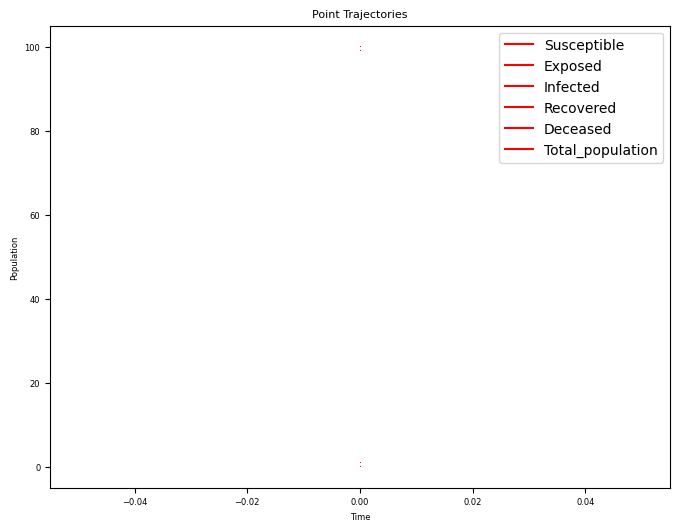

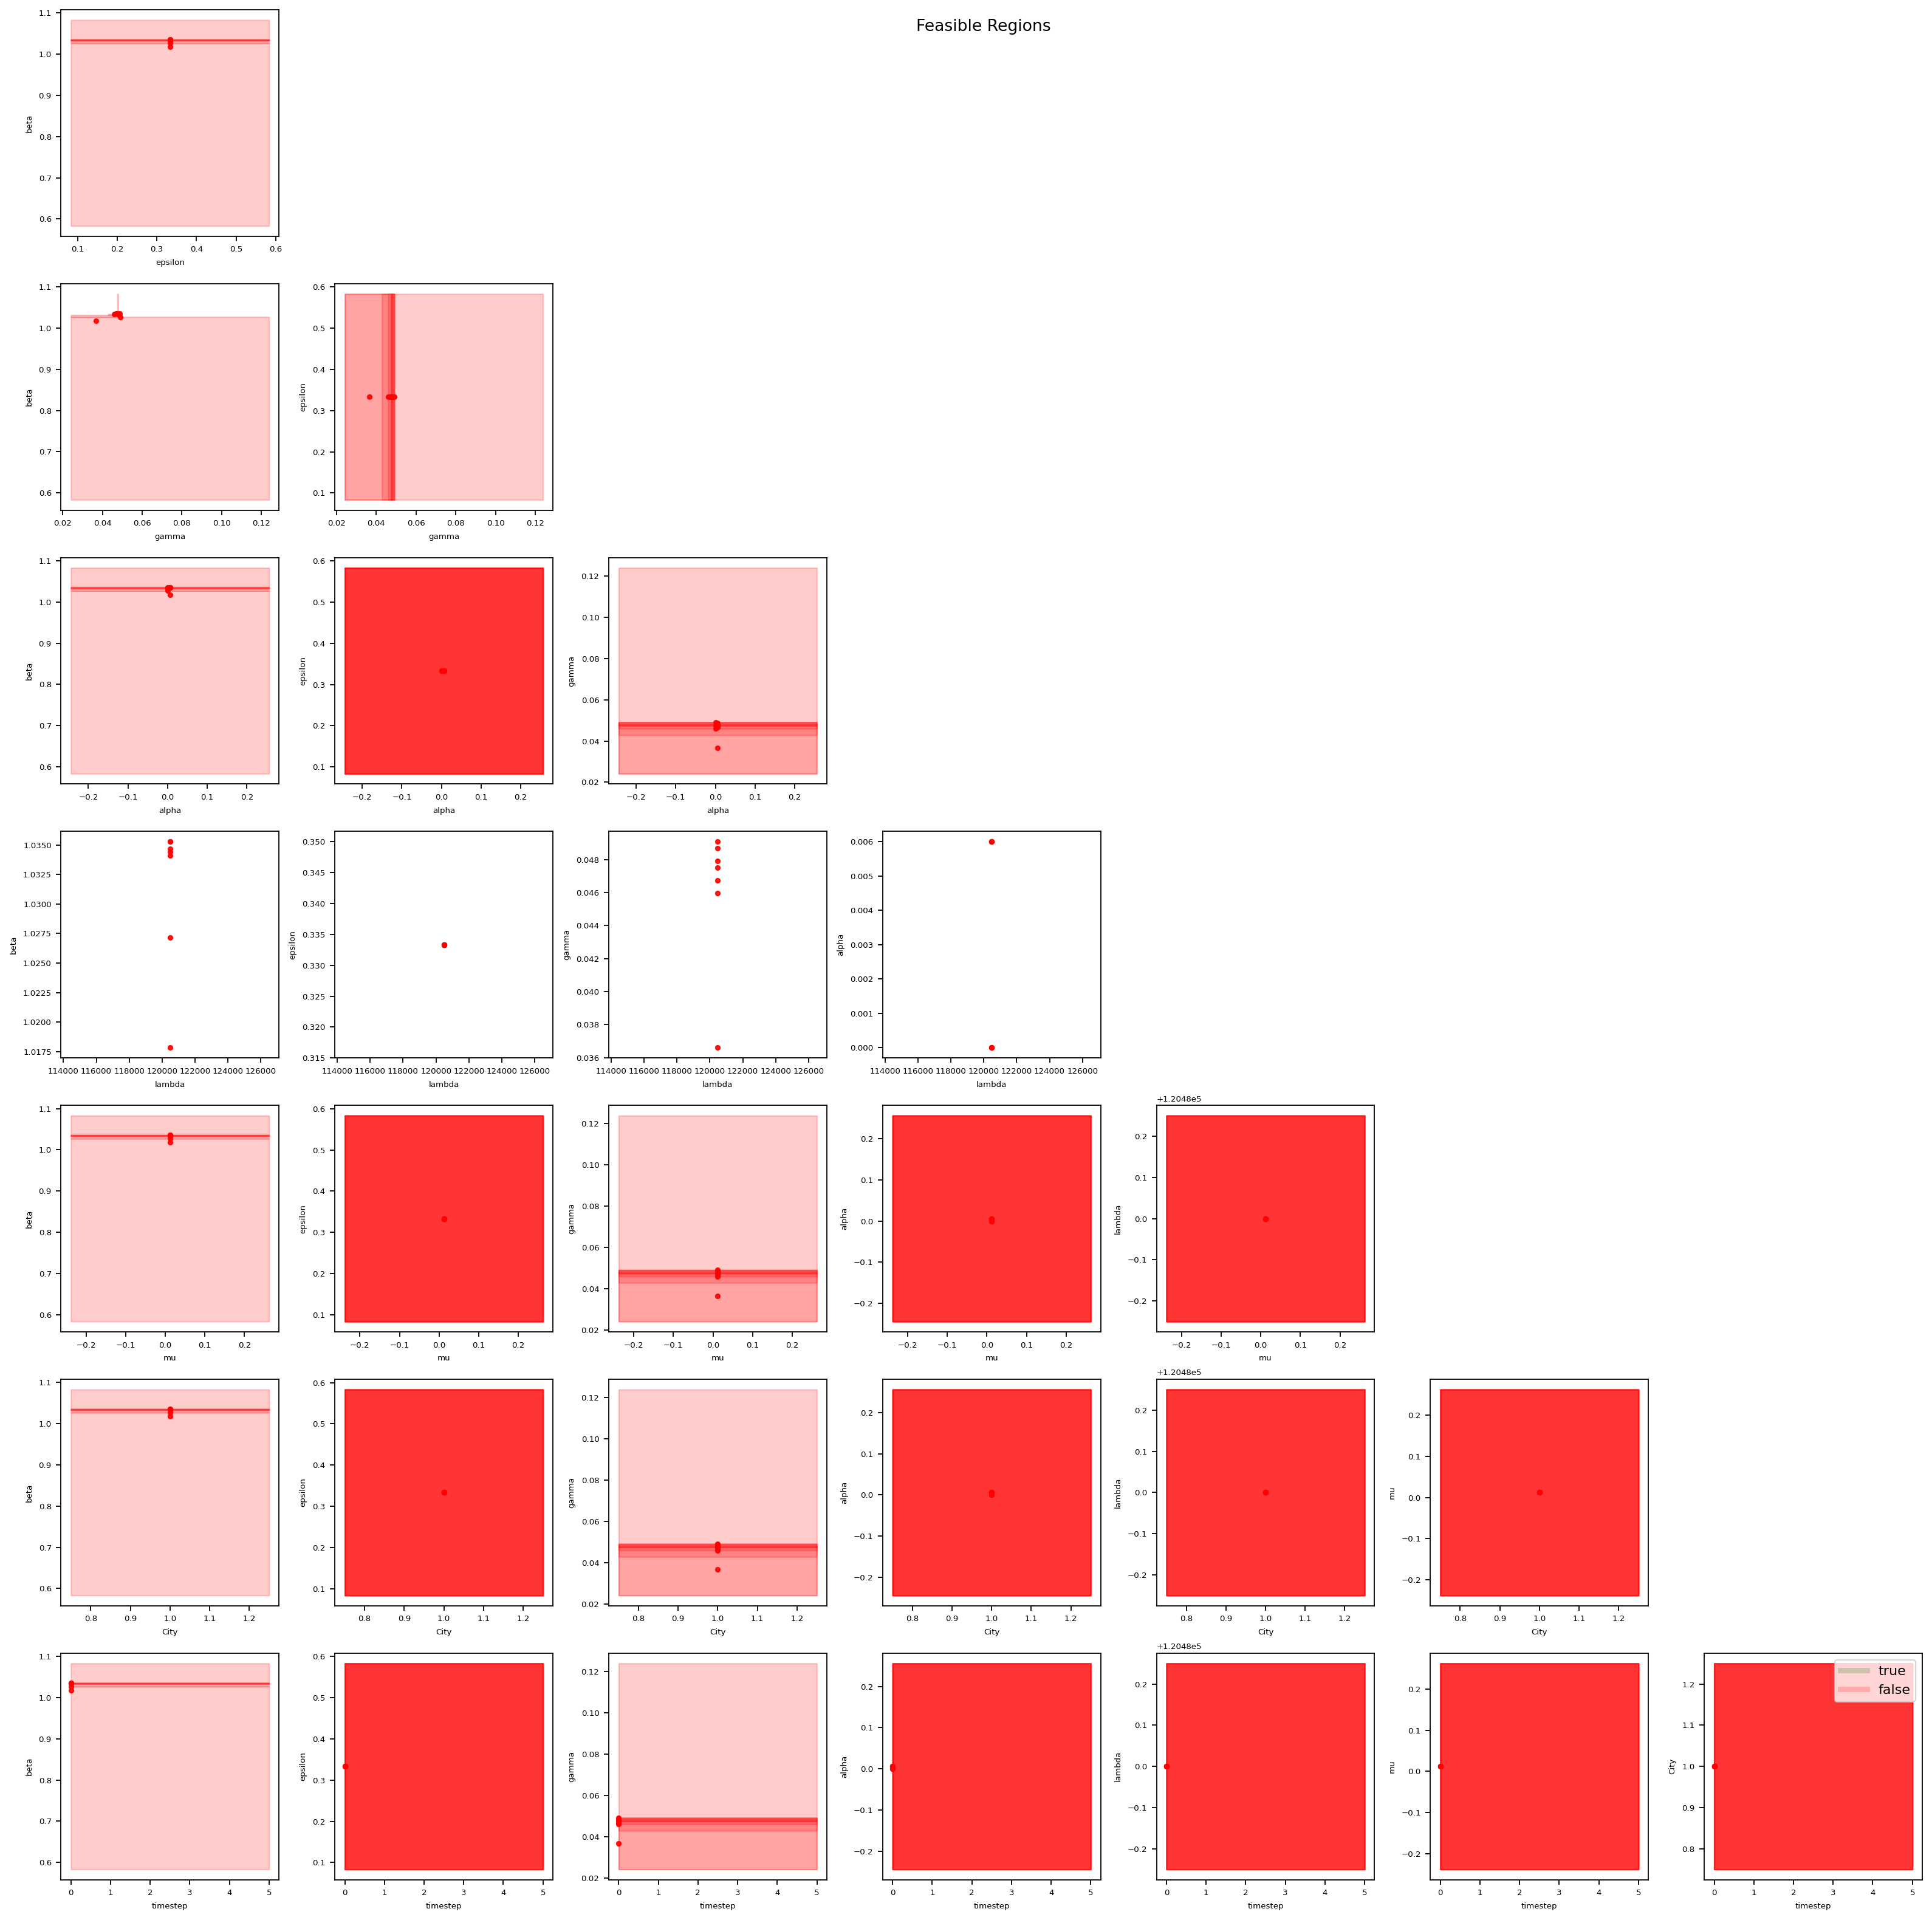

********************************************************************************
********************************************************************************
* Analysis Summary
********************************************************************************
7 Points (+:0, -:7), 7 Boxes (+:0, -:7)
Parameters = {beta[0.5830000000000001, 1.0830000000000002): 1.03528598134976, epsilon[0.08333333333333331, 0.5833333333333334): 0.3333333333333334, gamma[-0.125, 0.375): 0.046738139180867444, alpha[-0.244, 0.256): 0.006000000000000005, lambda[120479.75, 120480.25): 120480.00000000001, mu[-0.237952, 0.262048): 0.012048000000000003, City[0.75, 1.25): 1.0000000000000002}
        # {beta[0.5830000000000001, 1.0830000000000002): 1.03528598134976, epsilon[0.08333333333333331, 0.5833333333333334): 0.3333333333333334, gamma[-0.125, 0.375): 0.046738139180867444, alpha[-0.244, 0.256): 0.006000000000000005, lambda[120479.75, 120480.25): 120480.00000000001, mu[-0.237952, 0.262048): 0.01204800000000000

In [4]:
# Feb 2024 Hackathon Scenario 3 (SEIRD)

EXAMPLE_DIR = os.path.join(RESOURCES, "amr", "petrinet", "mira")
MODEL_PATH = os.path.join(
    EXAMPLE_DIR, "models", "scenario_3_seird.json"
)
REQUEST_PATH = os.path.join(
    EXAMPLE_DIR, "requests", "scenario_3_seird_request.json"
)


N = "Total_population"
STATES = ["Susceptible", "Exposed", "Infected", "Recovered", "Deceased"]
COMPARTMENTS = STATES + [N]

with open(REQUEST_PATH, "r") as request:
    funman_request = FunmanWorkRequest.model_validate(json.load(request))
    funman_request.structure_parameters[0].schedules[0] = EncodingSchedule(timepoints=list(range(0, 60, 10)))

    # funman_request.config.substitute_subformulas = True
    # funman_request.config.use_transition_symbols = True
    funman_request.config.use_compartmental_constraints=False
    funman_request.config.save_smtlib="./out"
    funman_request.config.tolerance = 0.001

    factor = 0.25
    to_synthesize = ["beta", "gamma"]
    for p in [po for po in funman_request.parameters if po.name not in []]:
        param = funman_request.parameter(p.name)
        param.interval.lb = p.interval.lb-factor
        param.interval.ub = p.interval.ub+factor
        param.label = "all" if p.name in to_synthesize else "any"

    # Susceptible is decreasing,  dS/dt < 0, S_{t+1} - S_t < 0
    c1 = LinearConstraint(name="c1", additive_bounds=Interval(ub=0), variables=["Susceptible"], timepoints=Interval(lb=0), derivative=True)
    funman_request.constraints.append(c1)

    # # R is increasing, dR/dt > 0, -dR/dt < 0,   - (R_{t+1} - R_t) < 0
    c2 = LinearConstraint(name="c2", additive_bounds=Interval(ub=0), variables=["Recovered"], weights=[-1], derivative=True)
    funman_request.constraints.append(c2)

    # # D is increasing, dD/dt > 0, -dD/dt < 0,   - (D_{t+1} - D_t) < 0
    c3 = LinearConstraint(name="c3", additive_bounds=Interval(ub=0), variables=["Deceased"], weights=[-1], derivative=True, timepoints=Interval(lb=0))
    funman_request.constraints.append(c3)

    # Population size maintained
    c4 = LinearConstraint(name="compartment", additive_bounds=Interval(lb=0, ub=0, closed_upper_bound=True), variables=COMPARTMENTS, weights=[1, 1, 1, 1, 1, -1])
    funman_request.constraints.append(c4)

    # # Infected peak
    # c5 = LinearConstraint(name="Infected_peak", additive_bounds=Interval(lb=50), variables=["Infected"], timepoints=Interval(lb=40, ub=40, closed_upper_bound=True))
    # funman_request.constraints.append(c5)

    for sv in STATES:
        funman_request.constraints.append(StateVariableConstraint(name=f"{sv}_bounds", variable=sv, interval=Interval(lb=0, ub=100, closed_upper_bound=True)))
    

    


    results_unconstrained_point = Runner().run(
            MODEL_PATH,
            funman_request,
            description="SEIRD demo",
            case_out_dir=SAVED_RESULTS_DIR,
    )
    summary = summarize_results(COMPARTMENTS, results_unconstrained_point, ylabel="Population")
    print(summary)

<Axes: xlabel='time'>

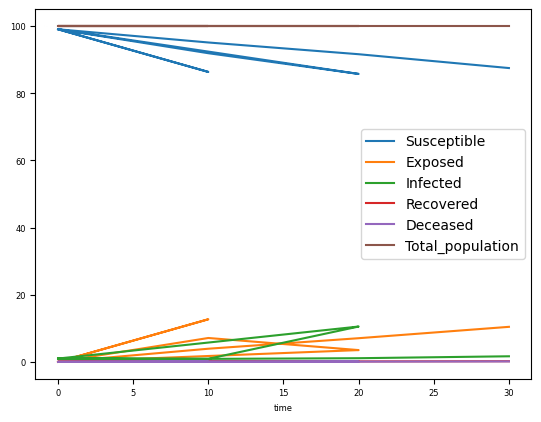

In [33]:
results_unconstrained_point.parameter_space.points()[0]
df= results_unconstrained_point.dataframe(
    results_unconstrained_point.parameter_space.points()
)
df[COMPARTMENTS].plot()


In [10]:
import textwrap
expr = results_unconstrained_point.parameter_space.false_boxes[0].explanation.expression
print(textwrap.fill(expr, 80))


((((((((((((((((((((assume_compartment & disj10) & (alpha =
30000000000000001/5000000000000000000)) & (gamma = 1/8)) & (epsilon =
8333333333333333/25000000000000000)) & (beta =
10412500000000001/12500000000000000)) & (Total_population_0 = 100.0)) &
(Total_population_1 = Total_population_0)) & (Infected_0 = 1.0)) & (Deceased_0 =
0.0)) & (Deceased_1 = (Deceased_0 - (alpha * Infected_0)))) & (Recovered_0 =
0.0)) & (Recovered_1 = (Recovered_0 - (gamma * Infected_0)))) & (Susceptible_0 =
99.0)) & (Exposed_0 = 0.0)) & (Exposed_1 = ((Exposed_0 + (epsilon * Exposed_0))
- (((beta * (Total_population_0 ^ -1.0)) * Infected_0) * Susceptible_0)))) &
(Infected_1 = (((Infected_0 - (alpha * Infected_0)) - (gamma * Infected_0)) +
(epsilon * Exposed_0)))) & (Susceptible_1 = (Susceptible_0 - (((beta *
(Total_population_0 ^ -1.0)) * Infected_0) * Susceptible_0)))) & ((conj12 | (!
assume_compartment)) | (! disj10))) & (((((((((((((((((((((((-1.0 *
Total_population_1) + Deceased_1) + Recovered_1) + Exposed_

In [ ]:
# SEIRHD

with open(REQUEST_PATH, "r") as request:
    funman_request = FunmanWorkRequest.model_validate(json.load(request))
    funman_request.structure_parameters[0].schedules[0] = EncodingSchedule(timepoints=[0, 1])

    # funman_request.config.substitute_subformulas = True
    # funman_request.config.use_transition_symbols = True
    funman_request.config.use_compartmental_constraints=False
    funman_request.config.save_smtlib="./out"

    for p in [po.name for po in funman_request.parameters if po.name not in ["S0", "I0", "E0", "R0", "H0", "D0", "N", "beta"]]:
    #["beta", "r_H_to_D", "r_E_to_I", "p_I_to_R", "r_I_to_R",  "p_I_to_H", "r_I_to_H", "p_H_to_R", "r_H_to_R","p_H_to_D","r_H_to_D"]:
        param = funman_request.parameter(p)
        param.interval.lb = 0
        param.interval.ub = 1

    # S is decreasing,  dS/dt < 0, S_{t+1} - S_t < 0
    c1 = LinearConstraint(name="c1", additive_bounds=Interval(ub=0), variables=["S"], derivative=True)
    funman_request.constraints.append(c1)

    # R is increasing, dR/dt > 0, -dR/dt < 0,   - (R_{t+1} - R_t) < 0
    c2 = LinearConstraint(name="c2", additive_bounds=Interval(ub=0), variables=["R"], weights=[-1], derivative=True)
    funman_request.constraints.append(c2)

    # D is increasing, dD/dt > 0, -dD/dt < 0,   - (D_{t+1} - D_t) < 0
    c3 = LinearConstraint(name="c3", additive_bounds=Interval(lb=0), variables=["D"], derivative=True)
    funman_request.constraints.append(c3)

    # Population size maintained
    c4 = LinearConstraint(name="compartment", additive_bounds=Interval(lb=0, ub=0, closed_upper_bound=True), variables=["S", "E", "I", "R", "D", "H", "N"], weights=[1, 1, 1, 1, 1, 1, -1])
    funman_request.constraints.append(c4)

    funman_request.constraints.append(StateVariableConstraint(name="SB", variable="S", interval=Interval(lb=0, ub=101, closed_upper_bound=True)))
    funman_request.constraints.append(StateVariableConstraint(name="EB", variable="E", interval=Interval(lb=0, ub=101, closed_upper_bound=True)))
    funman_request.constraints.append(StateVariableConstraint(name="IB", variable="I", interval=Interval(lb=0, ub=101, closed_upper_bound=True)))
    funman_request.constraints.append(StateVariableConstraint(name="RB", variable="R", interval=Interval(lb=0, ub=101, closed_upper_bound=True)))
    funman_request.constraints.append(StateVariableConstraint(name="DB", variable="D", interval=Interval(lb=0, ub=101, closed_upper_bound=True)))
    funman_request.constraints.append(StateVariableConstraint(name="HB", variable="H", interval=Interval(lb=0, ub=101, closed_upper_bound=True)))
    results_unconstrained_point = Runner().run(
            MODEL_PATH,
            funman_request,
            description="SEIRD demo",
            case_out_dir=SAVED_RESULTS_DIR,
    )
    summary = summarize_results(["S", "E", "I", "R", "H", "D"], results_unconstrained_point, ylabel="Population")
    print(summary)

In [9]:
json.loads(c2.model_dump_json())

{'soft': True,
 'name': 'c2',
 'timepoints': None,
 'additive_bounds': {'lb': -1.7976931348623157e+308,
  'ub': 0.0,
  'closed_upper_bound': False,
  'original_width': 1.7976931348623157e+308},
 'variables': ['R'],
 'weights': [-1],
 'derivative': True}

In [ ]:
import json
json.loads(results_unconstrained_point.parameter_space.false_boxes[0].explanation.model_dump_json())#['relevant_assumptions']

In [ ]:
results_unconstrained_point.parameter_space.points()[0]
df= results_unconstrained_point.dataframe(
    results_unconstrained_point.parameter_space.points()
)
df[["S", "E", "I", "R", "H", "D"]]
# df["S"]+df["E"]+df["I"]+df["D"]

In [ ]:
# Stratified

with open(REQUEST_PATH, "r") as request:
    funman_request = FunmanWorkRequest.model_validate(json.load(request))
    funman_request.structure_parameters[0].schedules[0] = EncodingSchedule(timepoints=[0,1, 2])
    funman_request.config.substitute_subformulas = True
    funman_request.config.use_transition_symbols = True
#     funman_request.config.use_compartmental_constraints=False
#     r_H_to_D = funman_request.parameter("r_H_to_D")
#     r_H_to_D.interval.lb = 0
#     r_H_to_D.interval.ub = 1.0

    # r_E_to_I = funman_request.parameter("r_E_to_I")
    # r_E_to_I.interval.lb = 0
    # r_E_to_I.interval.ub = 1.0


    results_unconstrained_point = Runner().run(
            MODEL_PATH,
            funman_request,
            description="SEIRD demo",
            case_out_dir=SAVED_RESULTS_DIR,
    )
    # summary = summarize_results(["S", "E", "I", "R", "D"], results_unconstrained_point, ylabel="Population")
    # print(summary)

In [ ]:
results_unconstrained_point.parameter_space.points()[0]